In [1]:
import numpy as np
import pickle
import os
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Input, Dropout,add, concatenate, Bidirectional
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf



In [2]:
from tensorflow.keras.utils import plot_model

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
def load_doc(path,doc_name):
    file = open(path+doc_name,"r")
    doc = file.read()
    return doc

In [6]:
! ls "/content/gdrive/My Drive/dataset/image_captioning"

descriptions1.txt	  embedding_matrix.pickle    Images
descriptions.txt	  final_model.h5	     train_features.pickle
embedding_matrix1.pickle  Flickr_8k.trainImages.txt


In [7]:
path = "/content/gdrive/My Drive/dataset/image_captioning"

In [8]:
doc = load_doc(path, "//descriptions1.txt")
descriptions = dict()
for line in doc.split("\n"):
    
    if(len(line)==0):
        break
    tokens = line.split() #spillting line into words
    image_id, image_desc = tokens[0], tokens[1:]
    
    image_id = image_id.split(".")[0] #we dont need the the file format
    image_desc = " ".join(image_desc)
    
    if image_id not in descriptions.keys():
        descriptions[image_id] = list()
    descriptions[image_id].append(image_desc)

In [9]:
vocabulary = set()
for key in descriptions.keys():
    [vocabulary.update(description.split()) for description in descriptions[key]]
print("orginal vacabulary size : {}".format(len(vocabulary))) 

orginal vacabulary size : 8357


In [10]:
filename = "//Flickr_8k.trainImages.txt"
doc= load_doc(path,filename)
train = list()
for line in doc.split("\n"):
    image = line.split('.')[0]
    train.append(image)
print("Train_size",len(train))


Train_size 6001


In [11]:
train_descriptions = dict()
for key, desc_list in descriptions.items():
    if key in train:
        train_descriptions[key] = desc_list

In [12]:
train_descriptions_modified = dict()
for key, desc_list in train_descriptions.items():
  for desc in desc_list:
    new_desc = "startseq " + desc +" endseq"
    if key not in train_descriptions_modified:
      train_descriptions_modified[key] = list()
    
    train_descriptions_modified[key].append(new_desc)

In [13]:
train_descriptions_modified[list(train_descriptions_modified.keys())[0]]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
#creating a list of all the captions
all_train_captions = []
for key, desc in train_descriptions_modified.items():
    for item in desc:
        all_train_captions.append(item)

In [15]:
#considererin only those words which are present more than the specified threshold in cosr
threshold = 10
word_counts = {}

for caption in all_train_captions:
    for word in caption.split():
        word_counts[word] = word_counts.get(word,0) + 1
        
vocab = [word for word in word_counts if word_counts[word] >= threshold]

print("processed words :", len(vocab))

processed words : 1643


In [16]:
vocab_size = len(vocab)

In [17]:
infile = open(path+"//train_features.pickle",'rb')
photos = pickle.load(infile)
infile.close()

In [18]:
print(len(photos.keys()))


6000


In [19]:
wordtoix = {}
intoword = {}
index = 0
for word in vocab:
    wordtoix[word] = index
    intoword[index] = word
    index +=1

In [20]:
wordtoix["endseq"]

13

In [21]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(description) for description in descriptions[key]]
    return all_desc
def max_length(descriptions):
         lines = to_lines(descriptions)
         return max([len(d.split()) for d in  lines])

In [22]:
max_len = max_length(train_descriptions_modified)
max_len

33

In [23]:
def data_generator(descriptions, photos, wordtoix, max_length, photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    #now we loop over every image and yield the data once n reaches photos_per_batch
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            #get the extracted photo features
            photo = photos[key+'.jpg']

            for desc in desc_list:
                #encode the sequence
                seq = [wordtoix[word] for word in desc.split() if word in wordtoix]
                #spliting one sequence into multiple input and corresponding outpur pairs
                for i in range(1, len(seq)):
                    
                    in_seq  = seq[:i]
                    out_seq = seq[i]

                    #padd input sequence
                    in_seq = pad_sequences([in_seq], maxlen = max_len)[0]
                    temp = out_seq
                    out_seq = np.zeros((vocab_size,))
                    out_seq[temp] = 1
                    out_seq = list(out_seq)
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                   
                    #yield the data
                if n >= photos_per_batch:
                 yield ([np.array(X1), np.array(X2)], np.array(y))
                 X1, X2, y = list(), list(), list()
                 n=0
                
                

In [24]:
train_descriptions_modified[next(iter(train_descriptions_modified))]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [25]:
generator = data_generator(train_descriptions_modified, photos, wordtoix, max_len, 1)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)
x1 = inputs[0]
x2 = inputs[1]
y = outputs

(14, 2048)
(14, 33)
(14, 1643)


In [26]:
infile = open(path+"//embedding_matrix1.pickle",'rb')
embedding_matrix = pickle.load(infile)
infile.close()

In [27]:
embedding_matrix.shape

(1643, 200)

In [28]:
embedding_dim = embedding_matrix.shape[1]

In [29]:
#image feature extractor model
inputs1 = Input(shape=(2048,))
fe1     = Dropout(0.5)(inputs1)
fe2     = Dense(256, activation="relu")(fe1)



In [30]:
# partial caption sequence model
'''inputs2 = Input(shape =(max_len,))
se1     = Embedding(1643, embedding_dim, mask_zero = True)(inputs2)
se2     = Dropout(0.5)(se1)
#se3     = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat')(se2)
#se3     = LSTM(units=256, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(se2)
se4    = LSTM(units=256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(se2)
'''

"inputs2 = Input(shape =(max_len,))\nse1     = Embedding(1643, embedding_dim, mask_zero = True)(inputs2)\nse2     = Dropout(0.5)(se1)\n#se3     = Bidirectional(LSTM(units=256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat')(se2)\n#se3     = LSTM(units=256, return_sequences=True, dropout=0.5, recurrent_dropout=0.2)(se2)\nse4    = LSTM(units=256, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(se2)\n"

In [31]:
inputs2 = Input(shape =(max_len,))
se1     = Embedding(1643, embedding_dim, mask_zero = True)(inputs2)
se2     = Dropout(0.5)(se1)
se3     = LSTM(256)(se2)

In [48]:
# decoder (feed forward) model
decoder1 =concatenate([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(1643, activation='softmax')(decoder2)

In [49]:
# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [50]:

model.layers

In [51]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [52]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = .001), metrics=['accuracy'])



model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 200)      328600      input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


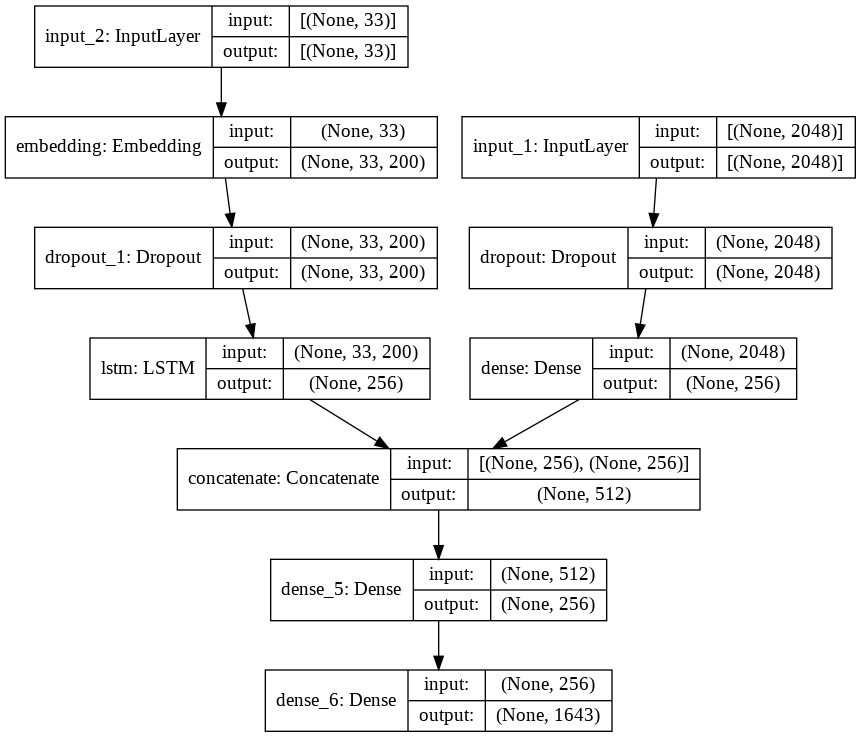

In [53]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [55]:
history = model.fit_generator(data_generator(descriptions=train_descriptions_modified, photos=photos, wordtoix= wordtoix, max_length = max_len, photos_per_batch=512),
                            steps_per_epoch=int(6000/512),
                            epochs=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
11/11 [==============================] - 97s 9s/step - loss: 2.6502 - accuracy: 0.3674
Epoch 2/5
11/11 [==============================] - 97s 9s/step - loss: 2.6385 - accuracy: 0.3688
Epoch 3/5
11/11 [==============================] - 98s 9s/step - loss: 2.6151 - accuracy: 0.3727
Epoch 4/5
11/11 [==============================] - 98s 9s/step - loss: 2.6107 - accuracy: 0.3739
Epoch 5/5
11/11 [==============================] - 97s 9s/step - loss: 2.6166 - accuracy: 0.3717


In [56]:
import matplotlib.pyplot as plt

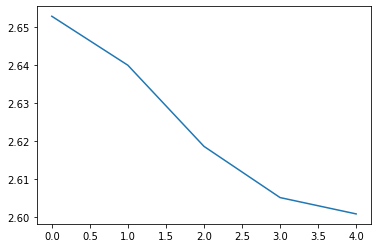

In [57]:
plt.plot(history.history["loss"])

In [58]:
model.save_weights(path+"//final_model.h5")

In [54]:
model.load_weights(path+"//final_model.h5")

In [59]:
generator = data_generator(train_descriptions_modified, photos, wordtoix, max_len, 1)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)
x1 = inputs[0]
x2 = inputs[1]
y = outputs

(14, 2048)
(14, 33)
(14, 1643)


In [41]:
out = model.predict([x1,x2])

In [66]:
len(intoword.keys())

1643

In [43]:
for column in out:
  print (intoword[np.argmax(column)])

woman
in
red
shirt
is
sitting
up
wooden
of
stairs
endseq
front
outdoor
endseq


In [ ]:
max_len

33

In [60]:
def get_captions(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_len)
        y_pred = model.predict([photo.reshape((1, 2048)),sequence])
        y_pred = np.argmax(y_pred)
        word = intoword[y_pred]
        in_text += ' ' + word
        if word == 'endseq':
            break
    genrated_caption = in_text.split()
    genrated_caption = genrated_caption[1:-1]
    genrated_caption = ' '.join(genrated_caption)
    return genrated_caption

In [63]:
pic = "47871819_db55ac4699.jpg"
get_captions(photos[pic])


'two soccer players chasing after soccer ball'

In [65]:


get_captions(photos["69189650_6687da7280.jpg"])

'brown dog is running through the grass'

In [71]:
get_captions(photos["221973402_ecb1cd51f1.jpg"])

'two dogs are playing with each other in the grass'